## 特征值

矩阵的特征值是高次方程的根, 难以直接求解. 在数值算法中, 可以通过迭代法得到精度要求内的近似解.

<br>

### 瑞利商 (Rayleigh Quotient)

若已知矩阵 $A$ 的一个特征向量 $x$, 由于 $Ax=\lambda x$, 可以求得对应的特征值 $\lambda =\frac{x^*Ax}{x^*x}.$ 因此如果能求出特征向量就能求出特征值.


### 幂法 (Power Method)

幂法是特征值问题的最古老的方法. 假设矩阵 $A$ 的特征值按模长排序 
$|\lambda_1|\geqslant |\lambda_2|\geqslant \dotsc \geqslant |\lambda_n| $, 且特征值 $\lambda_i$ 对应的特征向量为 $x_i$. 现在考虑简单版本的问题, 若 $A$ 和取定一个向量 $x$ 满足以下条件:

1. 模长最大的特征值是唯一的, 即 $|\lambda_1| > |\lambda_2|$.
2. 所取向量 $x$ 可以用 $A$ 的特征向量线性表示 $x=a_1x_1 + \dotsc +a_nx_n$ 且 $a_1\neq 0$.

那么
$$A^kx = A^k(a_1x_1 + \dotsc +a_nx_n)=a_1\lambda_1^kx_1+\dotsc+a_n\lambda_n^kx_n
=\lambda_1^k(a_1x_1+\sum_{i=2}^n\left(\frac{\lambda_i}{\lambda_1}\right)^ka_ix_i).$$

因此, 若 $k\rightarrow \infty$, 有 $A^kx \rightarrow \lambda_1^ka_1x_1$. 这可以理解为, $A^kx$ 的方向会趋近于特征向量 $x_1$ 的方向. 所以可以通过计算 $A^kx$ (的极限) 求得 $x_1$ 的方向. 由于范数大小并不影响方向, 可以每乘一个 $A$ 都规范化 (normalization) 一下使范数不会变得无穷大.

In [80]:
import numpy as np
def PowerMethod(A):
    eps = np.linalg.norm(A) * 2e-16 # 精度
    eigenvalue , eigenvalue2 = 1 , 0
    x = np.random.randn(A.shape[0]) + np.random.randn(A.shape[0])*1j
    x /= np.linalg.norm(x)
    while abs(eigenvalue2 - eigenvalue) > eps: # 如果两次估计特征值相差 < eps 则认为收敛
        eigenvalue = eigenvalue2
        Ax = A @ x
        eigenvalue2 = np.dot(x.conj(),Ax) # 估计特征值
        x = Ax / np.linalg.norm(Ax)       # 始终保持范数为 1
    return eigenvalue2

n = 100
np.random.seed(2)
A = (np.random.randn(n*n)+np.random.randn(n*n)*1j).reshape((n,n))
print('Max Eigenvalue by Power Method =',PowerMethod(A))
print('Max Eigenvalue by Numpy        =',max(np.linalg.eigvals(A), key= lambda x: abs(x)))

Max Eigenvalue by Power Method = (-1.0503730876433284+15.683571860511474j)
Max Eigenvalue by Numpy        = (-1.0503730876433526+15.683571860511448j)


需要注意 :
1. 实矩阵如果模长最大的特征值是复根, 则根据虚根成对原理有两个模长最大的特征值, 采用幂法很可能不收敛.
2. 为计算 $A^kx$, 应该用 $A$ 左乘 $x$ 共 $k$ 次, 而不应通过矩阵快速幂先计算 $A^k$. 理由是一次矩阵乘法是 $O(n^3)$ 复杂度, 已经足够做 $n$ 次迭代!
3. 从上述证明来看, 收敛速度和 $\left|\frac{\lambda_2}{\lambda_1}\right|$ 有关, 该值越小则收敛越快.

由于幂法在 $\left|\frac{\lambda_2}{\lambda_1}\right|\approx 1$ 可能收敛很慢, 且只能计算最大特征值, 现在几乎不会用朴素的幂法. 但是幂法衍生出了一系列的特征值算法.

### 反幂法 (Inverse Iteration)

如果 $\lambda$ 是 $A$ 的特征值, 那么 $\frac{1}{\lambda - \lambda_0}$ 是 $(A-\lambda_0I)^{-1}$ 的特征值. 当 $\lambda_0$ 很接近 $\lambda$, 那么 $\frac{1}{\lambda - \lambda_0}$ 是 $(A-\lambda_0I)^{-1}$ 模长最大的特征值, 且可以远远大于第二名. 这说明, 如果要计算 $A$ 最接近 $\lambda_0$ 的特征值, 改用幂法计算  $(A-\lambda_0I)^{-1}$ 可以收敛很快. 

即每一步用 $(A-\lambda_0I)^{-1}$ 左乘向量 $x$, 也即解线性方程组. 如果迭代次数 $ < n$ 次, 不宜求逆矩阵, 而可以提前做好 LU 分解, 每次只需解两个三角方程组. 

In [88]:
# 计算 A 最接近 eigenvalue 的特征值
# 如果 verbose = 1, 额外返回计算特征值的历史
def InverseIteration(A,eig,verbose = 1):
    for i in range(A.shape[0]):
        A[i,i] -= eig

    eps = np.linalg.norm(A) * 2e-16 # 精度
    eigenvalue , eigenvalue2 , history = 1 , 0 , [eig]
    x = np.random.randn(A.shape[0]) + np.random.randn(A.shape[0])*1j
    x /= np.linalg.norm(x)
    while abs(eigenvalue2 - eigenvalue) > eps: # 如果两次估计特征值相差 < eps 则认为收敛
        eigenvalue = eigenvalue2
        Ax = np.linalg.solve(A,x)
        eigenvalue2 = np.dot(x.conj(),Ax) # 估计特征值
        x = Ax / np.linalg.norm(Ax)       # 始终保持范数为 1
        history.append(1./eigenvalue2 + eig)

    for i in range(A.shape[0]): # 还原
        A[i,i] += eig
    
    if verbose:
        return 1./eigenvalue2 + eig , history
    else:
        return 1./eigenvalue2 + eig 

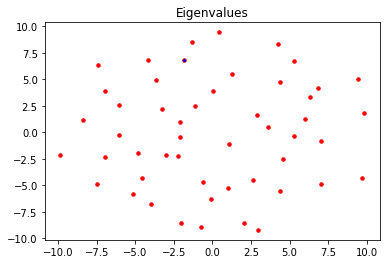

In [89]:
n = 50
np.random.seed(0)
A = (np.random.randn(n*n)+np.random.randn(n*n)*1j).reshape((n,n))


# 在复平面上看一下特征值的分布
import matplotlib.pyplot as plt
eigs = np.linalg.eigvals(A)
plt.scatter([eig.real for eig in eigs], [eig.imag for eig in eigs],s=12,c='r')

# 用反幂法求一个特征值并画在复平面上
my_eig = InverseIteration(A,-2.5+7.5j,verbose=0)
plt.scatter([my_eig.real],[my_eig.imag],s=4,c='b')
plt.title('Eigenvalues')
plt.show()

### Rayleigh商迭代法 (Rayleigh Quotient Iteration)

在上述过程中, 虽然 $\lambda_0$ 是固定不变的, 但是我们可以利用每次迭代求得的新的近似的 $\lambda$, 因为它距离真实特征值更近, 故用这个 $\lambda$ 替换原来的 $\lambda_0$ 效果更佳. 一般说来 Rayleigh 商迭代法收敛速度远快于 反幂法, 但求得的特征值未必是最接近 $\lambda_0$ 的.

In [90]:
def RayleighQuotientIteration(A,eigenvalue2,verbose=1):
    eps = np.linalg.norm(A) * 2e-16 # 精度
    eigenvalue , eigenvalue2 , history = eigenvalue2 - 1 , eigenvalue2 , [eigenvalue2]
    x = np.random.randn(A.shape[0]) + np.random.randn(A.shape[0])*1j
    x /= np.linalg.norm(x)
    while abs(eigenvalue2 - eigenvalue) > eps: # 如果两次估计特征值相差 < eps 则认为收敛
        eigenvalue = eigenvalue2
        for i in range(A.shape[0]):
            A[i,i] -= eigenvalue

        Ax = np.linalg.solve(A,x)

        for i in range(A.shape[0]): # 还原
            A[i,i] += eigenvalue

        eigenvalue2 = 1./ np.dot(x.conj(),Ax) + eigenvalue # 估计特征值
        x = Ax / np.linalg.norm(Ax)                        # 始终保持范数为 1
        history.append(eigenvalue)
    
    if verbose:
        return eigenvalue2, history[1:]
    else:
        return eigenvalue2

Eigenvalue by Inverse  = (2.1487525678093+0.5504326167827873j)
Eigenvalue by Rayleigh = (2.1487525678092965+0.5504326167827922j)
Eigenvalue Nearest to Inverse  = (2.1487525678092867+0.5504326167827807j)
Eigenvalue Nearest to Rayleigh = (2.1487525678092867+0.5504326167827807j)


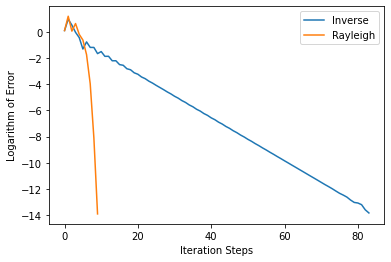

In [96]:
# 采用一个例子比较 Rayleigh商迭代法 与 反幂法 的收敛速度
n = 100
np.random.seed(0)
A = (np.random.randn(n*n)+np.random.randn(n*n)*1j).reshape((n,n))


# 用反幂法 / Rayleigh商迭代法求一个特征值
eig1, history1 = InverseIteration(A,1+1j,verbose=1)
eig2, history2 = RayleighQuotientIteration(A,1+1j,verbose=1)
print('Eigenvalue by Inverse  =',eig1)
print('Eigenvalue by Rayleigh =',eig2)

# 找到最接近 eig1, eig2 的特征值
eigs = np.linalg.eigvals(A)
real_eig1 = min(eigs ,key=lambda x: abs(x-eig1))
real_eig2 = min(eigs ,key=lambda x: abs(x-eig2))
print('Eigenvalue Nearest to Inverse  =',real_eig1)
print('Eigenvalue Nearest to Rayleigh =',real_eig2)

# 观察一下距离真实值的距离
plt.plot(range(len(history1)),np.log10(abs(history1-real_eig1)))
plt.plot(range(len(history2)),np.log10(abs(history2-real_eig2)))
plt.legend(['Inverse','Rayleigh'])
plt.ylabel('Logarithm of Error')
plt.xlabel('Iteration Steps')
plt.show()

### 收敛次数

假设数列 $x_k\rightarrow x_*$, 若存在常数 $C,\alpha $ 满足对于充分大的 $k$ 都有
$$\Vert x_{k+1} - x_*\Vert \leqslant C\Vert x_k - x_*\Vert^\alpha $$

则称该数列是 $\alpha$ 次收敛的. 幂法的收敛次数是一次的, 而 Rayleigh 商迭代法至少是二次收敛甚至是三次收敛. ([1] pp. 201, [2] pp. 453)

## References
1. 徐树方,高立,张平文, 数值线性代数, The Peking University Press, 2nd ed., 2013.
2. G. Golub and C. Van Loan, Matrix Computations, The Johns Hopkins University Press, Baltimore, Maryland, 4th ed., 2013.